<a href="https://colab.research.google.com/github/santboia/Curs_CausalDS/blob/main/lecture_notes/pscore_oil_wells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Propensity Score Matching with Dowhy to de-bias causal estimates

In this notebook we introduce the use of propensity score methods as provided by Microsoft's DoWhy library to estimate the magnitude of causal effects.

We illustrate this by estimating the effect of a subscription or rewards programme (*treatment*) on customer spend (*outcome*).

Suppose that a website has a membership rewards program where customers receive additional benefits if they sign up. How do we know if the program is effective? At the end of the day, it may just be the more engaged customers are also those that sign up for the program!

Hence, the relevant causal question is:
> What is the impact of offering the membership rewards program on total sales?

And the equivalent counterfactual question is, 
> If the current members had not signed up for the program, how much less would they have spent on the website?

In language of causal inference, we are interested in the *Average Treatment Effect on the Treated* (ATT):

𝐴𝑇𝑇=𝐸[𝑌(𝑇=1)−𝑌(𝑇=0)|𝑇=1]=𝐸[𝑌(𝑇=1)|𝑇=1]−𝐸[𝑌(𝑇=0)|𝑇=1]

Note the counterfactual nature of both this causal effect:
- the first term on the right hand side is the average spend by members of the programme (T=1), a potentially observable quantity;
- the second term is the average spend by non-members *had they been members*: this cannot be observed, though we may have a control group or modelling strategy that provides a consistent estimate.

## Creating a synthetic dataset

Suppose that the rewards program was introduced in January 2019. The `outcome` variable is the total spends at the end of the year. We have data on all monthly transactions of every user and on the time of signup for those who chose to signup for the rewards program. Here’s what the data looks like:


In [19]:
wells = np.arange(num_wells)
wells_ceramic = np.random.choice(wells, size=num_ceramic, replace=False)
proppant = np.zeros_like(wells)
proppant[sorted(wells_ceramic)] = 1
proppant.sum(), len(proppant)
idx = sorted(wells_ceramic)[:3]
print(idx)
proppant[idx]

[33, 98, 205]


array([1, 1, 1])

In [71]:
import pandas as pd
import numpy as np
num_cer = 189
num_sand = 5578
num_wells = num_cer + num_sand

# treatment = proppants: 0=sand, 1=ceramic
#proppants = 
wells = np.arange(num_wells)
random_seed = 12345
rng = np.random.default_rng(random_seed)
wells_cer = rng.choice(wells, size=num_ceramic, replace=False)
proppant = np.zeros_like(wells) #, dtype=bool)
proppant[sorted(wells_ceramic)] = 1

df = pd.DataFrame({
    'well_id': wells, #
    'proppant': proppant, # proppant = 0 for sand, = 1 for ceramic
})
df.head()

,well_id,proppant
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [72]:
# Define two latitude and longitude vectors around two geographical clusters:

# Distribute 2/3 of the sand wells in a broad (east-west) band
# north of Montrose, PA (N of Wilkes-Barre)
frac_sand = 2/3
num_sand_north = np.ceil(num_sand * frac_sand).astype(int)
num_sand_south = num_sand - num_sand_north
north_centre = np.array([41.901, -75.920])
north_max = np.array([41.989902, -75.519])
north_std = np.array([north_max[0]-north_centre[0], -75.712 - (-77.096)])
north_lon = rng.normal(loc=north_centre[0], scale=np.abs(north_std[0]), 
                       size=num_sand_north)
north_lat = rng.normal(loc=north_centre[1], scale=np.abs(north_std[1]), 
                       size=num_sand_north)
# Distribute half the ceramic wells in a narrower band latitude-wise:
frac_cer = 0.5 #2/3
num_cer_north = np.ceil(num_cer * frac_cer).astype(int)
num_cer_south = num_cer - num_cer_north
cer_north_centre = north_centre
cer_north_max = north_max
cer_north_std = np.array([cer_north_max[0]-cer_north_centre[0], 
                          2*(-75.712 - (-75.880))])
cer_north_lon = rng.normal(loc=cer_north_centre[0], scale=np.abs(cer_north_std[0]), 
                       size=num_cer_north)
cer_north_lat = rng.normal(loc=north_centre[1], scale=np.abs(cer_north_std[1]), 
                       size=num_cer_north)

In [73]:
# Distribute remaining 1/3 of the sand wells in a circular area 
# around Butler, PA (N of Pittsburgh, PA): (40.850, -79.877)
#num_sand_south = num_sand - num_sand_north
south_centre = np.array([40.850, -79.877]) # Butler, PA
south_max = np.array([40.676, -79.393]) # halfway btw Butler and Pittsburgh
south_std = np.array([south_max[0]-south_centre[0], 
                      south_max[1]-south_centre[1]])
south_lon = rng.normal(loc=south_centre[0], scale=np.abs(south_std[0]), 
                       size=num_sand_south)
south_lat = rng.normal(loc=south_centre[1], scale=np.abs(south_std[1]), 
                       size=num_sand_south)
# Distribute remaining half the ceramic wells in a smaller circle
# a bit further north from Butler, PA:
#num_cer_south = np.ceil(num_cer/2).astype(int)
num_cer_south = num_cer - num_cer_north
cer_south_centre = np.array([40.912, -79.850]) # bit further N from Butler, PA
cer_south_std = 0.5*south_std # smaller radius in both lon and lat
cer_south_lon = rng.normal(loc=cer_south_centre[0], scale=np.abs(cer_south_std[0]), 
                       size=num_cer_south)
cer_south_lat = rng.normal(loc=south_centre[1], scale=np.abs(cer_south_std[1]), 
                       size=num_cer_south)

In [74]:
# Overview of latitude and longitude means for sand and ceramic wells:
lon_sand = np.concatenate((north_lon, south_lon), axis=0)
lon_cer = np.concatenate((cer_north_lon, cer_south_lon), axis=0)
print( len(lon_sand), np.mean(lon_sand), len(lon_cer), np.mean(lon_cer) )

lat_sand = np.concatenate((north_lat, south_lat), axis=0)
lat_cer = np.concatenate((cer_north_lat, cer_south_lat), axis=0)
len(lat_sand), np.mean(lat_sand), len(lat_cer), np.mean(lat_cer)

5578 41.55238206712042 189 41.42009562743826


(5578, -77.24572368415336, 189, -77.86408534557413)

In [75]:
# add longitudes and latitudes for the wells to the df:
df['lon'] = 0.
df['lat'] = 0.
# sand wells:
df.loc[df['proppant']==0, 'lon'] = lon_sand
df.loc[df['proppant']==0, 'lat'] = lat_sand
# ceramic wells:
df.loc[df['proppant']==1, 'lon'] = lon_cer
df.loc[df['proppant']==1, 'lat'] = lat_cer
df.head()

,well_id,proppant,lon,lat
0,0,0,41.968156,-73.990147
1,1,0,41.797951,-77.817305
2,2,0,42.092167,-76.688670
3,3,0,41.887641,-74.028092
4,4,0,41.886672,-77.281208


In [76]:
# these means should agree with the ones calculated above:
df.groupby('proppant')[['lon', 'lat']].mean()

,lon,lat
proppant,,
0,41.552382,-77.245724
1,41.420096,-77.864085


In [87]:
# add a few covariates that are normally-distributed random variables:
output = {'cer': 1.88,    'sand': 1.41    } # 1-year gas production (bcf)
fspac = { 'cer': 239.2,   'sand': 273.0   } # fracture spacing (ft)
depth = { 'cer': 7004.,   'sand': 6981.   } # vertical depth (ft)
length = {'cer': 5225.,   'sand': 5210.   } # lateral length (ft) 
pint = {  'cer': 1447.,   'sand': 1477.   } # proppant intensity (lbs/ft)

feat_names = ['output', 'fspac', 'depth', 'length', 'pint']
features = [output, fspac, depth, length, pint]

for idx, featn in enumerate(feat_names):
#    print(featn)
    df[featn] = pd.Series(0, index=df.index)
    feat = features[idx]
    # sand wells:
    ctr = feat['sand']
    std = np.sqrt(ctr)
    df.loc[df['proppant']==0, featn] = rng.normal(loc=ctr, scale=std, size=num_sand)
    # ceramic wells:
    ctr = feat['cer']
    std = np.sqrt(ctr)
    df.loc[df['proppant']==1, featn] = rng.normal(loc=ctr, scale=std, size=num_cer)

#df.groupby('proppant').describe() # outputs includes mean,std,min,max,percentiles for each col!
df.groupby('proppant').mean()
#df.groupby('proppant').aggregate(['mean', np.std])


,well_id,lon,lat,fspac,depth,length,pint,output
proppant,,,,,,,,
0,2885.202223,41.552382,-77.245724,273.224299,6980.732592,5209.411672,1476.449497,1.417031
1,2818.005291,41.420096,-77.864085,238.427330,6995.579252,5226.239771,1450.698011,1.743639


## Naive estimate

We calculate the average spend of registered customers after they sign up, and compare that with the average spend of customers who didn't sign up.

We will analyse data comparing customers that never signed up (`signup_month=0`) with those that signed up in June (`signup_month=6`). This allows us enough spending data before and after sign-up for a reasonable analysis.

In [93]:
# Output of sand-drilled wells:
y1 = df.loc[df['proppant']==1, "output"].mean()
# Output of ceramic-drilled wells:
y0 = df.loc[df['proppant']==0, "output"].mean()

print("Observational estimate of effect: {:.2} bcf, or {:+.1%}".format(y1-y0, y1/y0-1.))

Observational estimate of effect: 0.33 bcf, or +23.0%


According to an simple estimate using the whole set of observed data, ceramic-drilled wells produce 23% more per year than sand-drilled wells.

## Enter DoWhy

To find out a better, less biased estimate of the true causal impact of customer registration on their spend, we will use DoWhy. We start loading the required libraries.

In [94]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

# install dowhy
import sys
!{sys.executable} -m pip install dowhy
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 123 kB 12.5 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [95]:
# install libgraphviz and pygraphviz for nicer-looking graphs:
!apt install libgraphviz-dev
import sys
!{sys.executable} -m pip install pygraphviz
import pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail-common amd64 2.24.32

## Building a causal model

We now build a graph incorporating our assumptions on the variables (features) that affect whether a customer *signs up to the programme* as well as the actual amount spent by a customer.

Our assumptions, stemming from our business knowledge, are:
- past expenditure is associated with whether a customer signs up or not: `pre_spend -> treatment`;
- past expenditure is *not* directly associated with future expenditures: no arrow from `pre_spend` to `post_spend`;
- signing up leads to a change (positive or negative) on post-signup spend:  `treatment -> post_spend`;
- more engaged customers will signup earlier ( `signup_month -> program_signup_in_month_i`) and also spend more before (`signup_month -> pre_spend`) and after (`signup_month -> post_spend`) signing up;
- there may be other variables affecting the month in which customers signup (`Z -> program_signup_in_month_i`) that do not directly affect spend before or after signing up;
- it is likely there are further unobserved variables that affect all of `program_signup_in_month_i`, `pre_spend` and `post_spend` ("Unobserved confounders).

In [96]:
df.columns

Index(['well_id', 'proppant', 'lon', 'lat', 'fspac', 'depth', 'length', 'pint',
       'output'],
      dtype='object')

In [107]:
df['treatment'] = df['proppant'].astype(bool)
df.head()

,well_id,proppant,lon,lat,fspac,depth,length,pint,output,treatment
0,0,0,41.968156,-73.990147,266.205064,6895.918378,5241.146199,1493.499678,1.386073,False
1,1,0,41.797951,-77.817305,281.274636,6989.719448,5139.778564,1430.236063,3.028000,False
2,2,0,42.092167,-76.688670,261.987765,6948.999599,5286.290194,1466.143483,0.552205,False
3,3,0,41.887641,-74.028092,309.613335,6891.927404,5320.846946,1483.316375,1.192897,False
4,4,0,41.886672,-77.281208,273.392669,6943.336605,5276.733418,1447.304495,0.528195,False


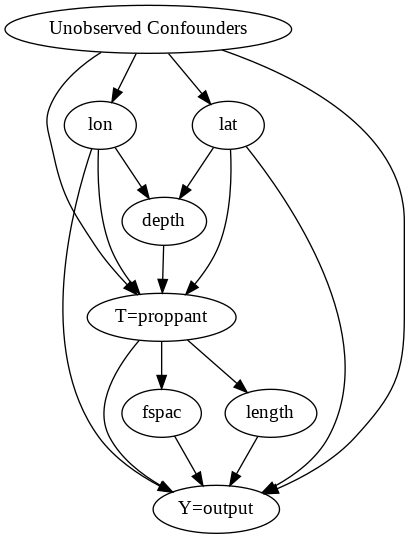

In [124]:
# complicated causal graph, with suff.adj.set={lon,lat,pint,depth} :
causal_graph = """digraph {
treatment[label="T=proppant"];
output[label="Y=output"];
lon;
lat;
fspac;
depth;
length;
U[label="Unobserved Confounders"];
lon -> treatment;
lat -> treatment;
lon -> output;
lat -> output;
depth -> treatment;
lon -> depth;
lat -> depth;
treatment -> fspac;
treatment -> output;
treatment -> length;
length -> output;
fspac -> output;
U->treatment; U->output; U->lon; U->lat; 
}"""

# Instantiate a causal model with the processed data and our causal graph:
model = dowhy.CausalModel(data=df,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="output")
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

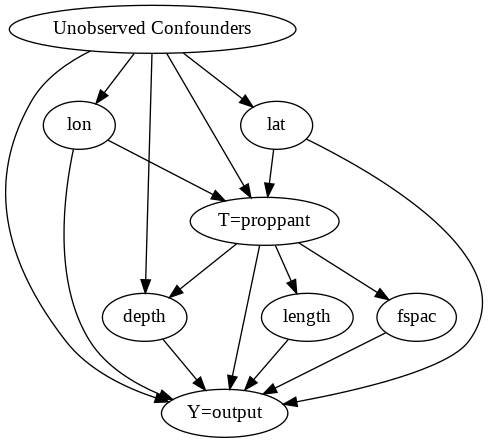

In [116]:
# simpler causal graph with only lon,lat as sufficient adjustment set:
causal_graph = """digraph {
treatment[label="T=proppant"];
output[label="Y=output"];
lon;
lat;
depth;
length;
U[label="Unobserved Confounders"];
lon -> treatment;
lat -> treatment;
lon -> output;
lat -> output;
treatment -> fspac;
treatment -> output;
treatment -> length;
treatment -> depth;
treatment -> fspac;
depth -> output;
length -> output;
fspac -> output;
U->treatment; U->output; U->lon; U->lat; U -> depth;
}"""

# Instantiate a causal model with the processed data and our causal graph:
model = dowhy.CausalModel(data=df,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="output")
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

## Identify the causal effect

We assume that `unobserved confounders` do not have an important impact to enable identifying the causal effect:

In [125]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                         
────────────(Expectation(output|lat,lon,depth))
d[treatment]                                   
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→output then P(output|treatment,lat,lon,depth,U) = P(output|treatment,lat,lon,depth)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Here, DoWhy informs us that it can provide estimates of the causal effect by two methods: the backdoor criterion and using `Z` as an instrumental variable (IV).

The expression in the backdoor case indicates that 
based on the causal graph, DoWhy has determined that the signup month (`signup_month`) and amount spent in the pre-treatment months (`pre_spend`) needs to be conditioned on.

*Instrumental variables are an econometric method of causal inference outside the scope of this workshop.*


## Numerical estimate of the causal effect

We now determine the causal estimate of the ATT using *propensity score matching*, i.e., identifying datapoints with similar values of covariates and differing only in the value of *treatment* to estimate the causal effect.

Other potential causal quantities of interest are:

- the *average treatment effect* (ATE):
$ ATE = E[Y(T=1)] - E[Y(T=0)]$

-  the Average Treatment Effect on Control (ATC): $ATC = E[Y(T=1)-Y(T=0)|T=0] =  E[Y(T=1)|T=0] - E[Y(T=0)|T=0]$


In [140]:
# Determine the causal estimate of the ATE
estimate = model.estimate_effect(identified_estimand,
                                 #method_name="backdoor1.propensity_score_stratification",
                                 method_name="backdoor1.propensity_score_matching",
                                target_units="ate")
print(estimate)

print("Causal estimate of effect: {:.2} bcf, or {:+.1%}".format(
    estimate.value, estimate.value/y0))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: output~treatment+lat+lon+depth
Target units: ate

## Estimate
Mean value: 0.25542401831325423

Causal estimate of effect: 0.26 bcf, or +18.0%


In [141]:
# We can take a look at the propensity scores:
estimate.propensity_scores.aggregate(['min', 'mean', 'max'])

min     0.028107
mean    0.032856
max     0.037635
Name: propensity_score, dtype: float64

In [142]:
print("Recall the fraction of wells that were treated is ", num_cer/num_wells)

Recall the fraction of wells that were treated is  0.03277267209987862


## Refuting the causal estimate

We emphasize again that the causal estimate does not come from data alone. It comes from our assumptions (represented in the causal graph), which underpin the identification step. 

Data is simply used for statistical estimation. Thus it becomes critical to verify whether our assumptions were even correct in the first step or not!

A first-principles verification of assumptions is out of the question, but we can subject our results to a number of refutation attempts -- if all come back as expected, we gain confidence that our causal graph is a good representation of the real-world situation.

We now describe some of the refutation methods available on DoWhy:

- *Placebo Treatment Refuter*: Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.

In [143]:
refutation = model.refute_estimate(identified_estimand, 
                                   estimate, 
                                   method_name="placebo_treatment_refuter",
                                   placebo_type="permute", num_simulations=2)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:0.25542401831325423
New effect:0.05243064018887222
p value:0.3395083425838632



We see that the new effect with the placebo ($\approx 0.05$) is much closer to zero than the initial estimate ($\approx 0.26$), reinforcing our confidence in it.

- *Random Common Cause*: Adds randomly drawn covariates to the data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.

In [144]:
refute_common_cause=model.refute_estimate(identified_estimand, 
                                          estimate,
                                          method_name="random_common_cause")
print(refute_common_cause)

Refute: Add a Random Common Cause
Estimated effect:0.25542401831325423
New effect:0.25542401831325423



The new estimate is similar to the initial one which suggests that it is not a random coincidence (it is robust to adding random noise).

- *Data Subset Refuter*: Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.

In [145]:
# Note: default value for num_simulations = 100, which can take a long time
refute_subset=model.refute_estimate(identified_estimand, 
                                      estimate,
                                      method_name="data_subset_refuter",
                                      num_simulations=3)
print(refute_subset)

Refute: Use a subset of data
Estimated effect:0.25542401831325423
New effect:0.25110401856001735
p value:0.46560713370775453



*Conclusion:*
We see that our estimate passes all three refutation tests. This does not prove its correctness, but it increases confidence in the estimate.

## Acknowledgement

This introductory notebook has been motivated by 
A. Bertoncello et al., "Using Causal Inference in Field Development Optimization: Application to Unconventional Plays", [Math Geosci (2020) 52:619–635](https://doi.org/10.1007/s11004-019-09847-z)